# How to Run this Notebook?

This notebook builds upon the notebook for Exercise 2: RAG with Reranker. The explanations that repeat from the previous notebook are greyed out in this notebook.

<font color="#d3d3d3">
1. Generate API key for OpenAI (ChatGPT): https://platform.openai.com/settings/organization/api-keys
Make sure to save the API key. You'll get to see the key only once at the time of generation. If you miss copying the key, you may need to generate a new key.<br>
2. Generate API token for HuggingFace Source: https://huggingface.co/settings/tokens/new?tokenType=write
Just like last time, make sure to save this API key as well.
<br>
3. Generate API key for Cohere: https://dashboard.cohere.com/api-keys<br>
4. Generate API key for LangChain to access its paid tracing tool, LangSmith: https://smith.langchain.com/settings
  Look out for `Create API Key` on the top right side of the settings page.<br>
5. Generate API key for SerpAPI to access Google search results: https://serpapi.com/users/sign_up?plan=free

6. Generate API key for Proxycurl to access Linkedin profile details: https://nubela.co/proxycurl/
  Look out for `Get a trial API key` after scrolling below a bit.
    
7. Click on 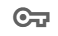 icon in the left menu bar of this Notebook

8. Click `+ Add new secret `

<font color="#d3d3d3">
- Add OpenAI key, if not added already:<br>
  * Under Name copy paste: `OPENAI_KEY`<br>
  * Under Value copy paste: OpenAI key you saved earlier<br>
- Add HuggingFace key, if not added already:<br>
  * Under Name copy paste: `HF_KEY`<br>
  * Under Value copy paste: HF key you saved earlier<br>
- Add Cohere key:<br>
  * Under Name copy paste: `COHERE_KEY`<br>
  * Under Value copy paste: Cohere key you saved earlier<br>
- Add LangChain key:
  * Under Name copy paste: `LANG_KEY`
  * Under Value copy paste: LangSmith key you saved earlier<br>
- Add SerpAPI key:
  * Under Name copy paste: `SERP_KEY`
  * Under Value copy paste: SerpAPI key you saved earlier

- Add Curl key:
  * Under Name copy paste: `CURL_KEY`
  * Under Value copy paste: ProxyCurl key you saved earlier

8. Enable access to the keys for this notebook by toggling the radio buttons in the `Secrets` section.
9. Close the `Secrets` section once done.
10. Click `Run all` under the `Runtime` in top menu to execute this notebook`


#Basic Setup
<font color="#d3d3d3">
**Install Frameworks**<br><br>
`langchain`, `langchain_core`, and `langchain_community` are components of the LangChain framework.<br><br>
`faiss-cpu` is Facebook AI's similarity search library, optimized for CPU usage.<br><br>
`openai==1.56.2` and `langchain_openai` are OpenAI's Python client library and LangChain's OpenAI integration package respectively.<br><br>
`Cohere` and `langchain_Cohere` are Cohere's Python client library and LangChain's Cohere integration package respectively.

<font color="#d3d3d3">`google-search-results`is used for retrieving search results from Google, potentially for augmenting the information used by the language models.

In [ ]:
%%capture
!pip install langchain langchain_core langchain_community faiss-cpu openai==1.56.2 langchain_openai cohere langchain_cohere google-search-results

**Import Packages**



In [ ]:
import os
from google.colab import userdata
from typing import List, Dict, Any, Tuple
import requests
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.embeddings import Embeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import time
import json

from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from urllib.parse import urljoin

import re

from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.tools import BaseTool
from langchain.utilities import SerpAPIWrapper
from langchain.agents import create_react_agent
from langchain.agents import AgentExecutor

**Project's Secret Keys Setup**

<font color="#d3d3d3">
This code sets up authentication credentials by retrieving API keys from Colab's `Secrets` storage.
<br>
Cohere's and LangChain's API key are also retreieved from Colab's `Secrets` storage.</font><br>
SERPApi key is also retrieved.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')
hfToken = userdata.get('HF_KEY')
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANG_KEY')
os.environ["SERPAPI_API_KEY"] = userdata.get('SERP_KEY')
os.environ["PROXYCURL_API_KEY"] = userdata.get('CURL_KEY')

# **LangChain Tracing Configuration by LangSmith**

<font color="#d3d3d3">This code configures LangChain to use LangSmith for tracing. LangSmith is a tool that helps you monitor and debug your LangChain applications. Tracing means that LangSmith will keep a record of every step your application takes, allowing you to see how it's working and identify any issues.<br>
-<font color="#d3d3d3"> `os.environ` is a way to access and modify environment variables in Python. Environment variables are like global settings for your system.<br>
-`LANGCHAIN_TRACING_V2` controls LangChain tracing. By setting it to "true", we are enabling LangChain tracing. This means that LangChain will start sending data to LangSmith.

-`LANGCHAIN_PROJECT`  specifies the name of the LangSmith project to use. In this example, `10_K_reflection` is the name of the project. You can create a new LangSmith project or use an existing one. Projects are a way to organize your tracing data in LangSmith.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "10_K_reflection"

# Configuration Dictionary
<font color="#d3d3d3">
Contains settings for document processing and RAG system, including parameters for text chunking, embedding generation, document retrieval, model specifications, prompts used and API endpoints.
Default config settings for Cohere's Reranker were also added.</font><br>
The keys needed for ReAct were added to the prompt.

In [ ]:
defaultConfig = {
    # Document processing settings
    "chunkSize": 500,
    "chunkOverlap": 50,
    "userAgentHeader": "YourCompany-ResearchBot/1.0 (your@email.com)",

    # Embedding settings
    "embeddingApiUrl": "https://api-inference.huggingface.co/models/BAAI/bge-base-en-v1.5",
    "embeddingDim": 768,

    #Defalt document
    "defaultDocument" : Document(
        page_content = "This is a default document.",
        metadata = {"source": "default"}
    ),

    # Vector store settings
    "numRetrievedDocuments": 12,

    # Document formatter settings
    "numSelectedDocuments": 5,

    #Reranker setting
    "rerankerModel": "rerank-english-v3.0",
    "numRerankedDocuments": 5,

    # Model settings
    "ragAnswerModel": "gpt-4o",
    "ragAnswerModelTemeprature": 0.7,

    # URLs to process
    "companyFilingUrls": [
        ("Tesla", "https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm"),
        ("General Motors", "https://www.sec.gov/Archives/edgar/data/1467858/000146785824000031/gm-20231231.htm")
    ],

    # RAG prompt template
    "ragPromptTemplate": """
    Give an answer for the `Question` using only the given `Context`. Use information relevant to the query from the entire context.
    Provide a detailed answer with thorough explanations, avoiding summaries.

    Question: {question}

    Context: {context}

    Answer:
    """,

    #Query Decomposer settings
    "numQueryDecomposerSelectedDocuments": 2,
    "queryDecomposerModel": "gpt-4o-mini",
    "queryDecomposerModelTemperature": 0.8,

    "subqueryPromptTemplate": """
    Break down the `Question` into multiple sub-queries. Use the guidelines given below to help in the task.

    1. The set of sub-queries together capture the complete information needed to answer the question.
    2. Each sub-query should ask for just one piece of information about one specific company.
    3. For each sub-query, only mention the information you're trying to get. Don't use verbs like "retrieve" or "find".
    4. Include the company name mentioned in each sub-query.
    5. Do not include any references to data sources in your sub-queries.

    Enclose the sub-query in angle brackets. For example:
    <sub-query 1>
    <sub-query 2>

    Question: {question}

    Begin:
    """,


    # Settings for ReAct
    "reactModelName": "gpt-4o",
    "reactModelTemperature": 0,

    "reactPromptTemplate": """Your task is to gather relevant information to build context for the question. Focus on collecting details related to the question.
    Gather as much context as possible before formulating your answer.

    You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer

    Thought: you should always think about what to do

    Action: the action to take, should be one of [{tool_names}]

    Action Input: the input to the action

    Observation: the result of the action

    ... (this Thought/Action/Action Input/Observation can repeat N times)

    Thought: I now know the final answer

    Final Answer: the final answer to the question.

    Follow these steps:

    Begin!

    Question: {input}

    Thought:{agent_scratchpad}
    """,

    "reactVerbosity": True,


    # Settings for Extracting Director's Name
    "nameExtractionModel": "gpt-4o-mini",
    "nameExtractionModelTemperature": 0.4,
    "nameExtractionPrompt": """
    Extract and list the names of all individuals with the title 'Director' from the following text, excluding any additional information such as dates or signatures.
    Present the names as a simple, comma-separated list.

    {text}
    """,

    # Director Information Tool settings
    "useDirectorTool": True,
    "directorToolName": "Company Directors Information",
    "directorToolDescription": "Retrieve the names of company directors for a chosen company. Optionally, their LinkedIn handles can also be included. Use the format: company_name, true/false.",

    # Web Search Tool settings
    "useWebTool": True,
    "webToolName": "WebSearch",
    "webToolDescription": "Performs a web search on the query.",
    "numWebToolResults": 3,

    # Database Retriever Tool settings
    "useRetrieverTool": True,
    "retrieverToolName": "Vector Reranker Search",
    "retrieverToolDescription": "Retrieves information from an embedding based vector DB containing financial data and company information. Structure query as a sentence",
    "numRetrieverToolResults": 3,

    # Director Background Info Tool settings
    "useLinkedinScraperTool": True,
    "linkedinScraperToolName": "Director's previous work and education",
    "linkedinScraperToolDescription": "Retrieves director's education and work experience using their LinkedIn URL. Use the format: url",


    # reflection settings
    "reactAgentMaxIterations": 25,

    "reflectionPromptTemplate": """Your task is to analyze whether the `Answer` is missing some information related to the `Question`.
    Give feedback on the missing requirments of the answer. Mention only the essential information.

    Here is the previous interaction:
    Question: {original_input}
    Answer: {current_output}

    Reflection:
    Provide brief, concise thoughts on what additional information needs to be collected in the next iteration.

    Based on your reflection, conclude with one of the following actions:

    If the current Answer provides sufficient information for Original Input, state "STOP".
    If further refinement is needed, provide 2-3 brief thoughts for improvement, each on a new line, and end with "CONTINUE".
    """,

        "reactPromptReflectionAddition": """Improve `Previous Answer` based on `Reflections`. Dont look for information already present in `Previous Answer`.
    Formulate a new Final Answer.

    Reflections: {reflections}

    Previous Answer: {previous_iteration}
    """,

    "reflectionMaxIterations": 2,

}


# Preprocessing Class
<font color="#d3d3d3">`FilingsPreProcessor` (Custom-defined class):
A custom class that downloads and preprocesses company filing documents from the web, splitting large filings into smaller text chunks for easier embedding and retrieval.<br>
`__init __`:
Constructor method that initializes the preprocessor with configuration parameters for chunk size, overlap, and an internal dictionary to store text chunks used specificially for extracting director names.<br>
`loadAndProcessFilings`:
Method that takes company filing URLs, downloads content, processes it into chunks, and stores the last 1000 characters for director names; returns processed documents and director name chunks.

- <font color="#d3d3d3">`Document` (Langchain class):
LangChain class representing a document with content and metadata, which is company name in this exercise.

- <font color="#d3d3d3">`WebBaseLoader` (Langchain class):
  * <font color="#d3d3d3">LangChain class that downloads content from the given 10-K company filing URLs with a custom User-Agent Header, which informs SEC website where the request is coming from and what kind of user agent it is. It's like introducing yourself when you enter a room, but for computer programs! This is often required for accessing web data, especially in responsible web scraping.

- <font color="#d3d3d3">`RecursiveCharacterTextSplitter` (Langchain class):
LangChain class that splits text documents into smaller chunks with specified size and overlap. It adds the company names as metadata for each chunk, then returns the processed chunks.
</font>

`directorNamesChunk` stores the last 1000 characters dedicated to extracting director names. This information is crucial for the CompanyDirectorsTool used later in the code.Addition of this feature enhances the capability of the system to extract and utilize director information, which can be valuable for answering complex queries about company leadership and governance.

In [ ]:
class FilingsPreProcessor:
    def __init__(self, config: Dict[str, Any]):
        self.chunkSize = config["chunkSize"]
        self.chunkOverlap = config["chunkOverlap"]
        self.userAgentHeader = config["userAgentHeader"]
        self.directorNamesChunk = {}

    # Using langchain class Document
    def loadAndProcessFilings(self, companyFilingUrls: List[Tuple[str, str]]) -> List[Document]:
        processedCompanyFilings = []

        for company, url in companyFilingUrls:
            try:
                # Using langchain class WebBaseLoader
                filingContent = WebBaseLoader(url, header_template = {'User-Agent': self.userAgentHeader}).load()

                self.directorNamesChunk[company] = filingContent[0].page_content[-1000:]

                # Using langchain class RecursiveCharacterTextSplitter
                splitFilingContent = RecursiveCharacterTextSplitter(
                    chunk_size = self.chunkSize,
                    chunk_overlap = self.chunkOverlap
                    ).transform_documents(filingContent)

                for split in splitFilingContent:
                    split.metadata.update({
                        'company': company,
                    })

                processedCompanyFilings.extend(splitFilingContent)

            except Exception as e:
                print(f"Error processing {url}: {str(e)}")
                continue

        return processedCompanyFilings, self.directorNamesChunk

# Embedding class
<font color="#d3d3d3">`EmbeddingService` (Custom-defined class):
A custom class that inherits from LangChain's Embeddings class, providing text embedding functionality through an external API<br>
`__init __`:
Constructor that initializes the service with API URL, headers, and embedding configuration
- <font color="#d3d3d3">Sets up the Hugging Face embedding API endpoint an headers
- Stores an instruction prefix that is added to user's query before embedding generation.
- Sets the embedding dimension size as per `embeddingDim` value in `defaultConfig` (e.g., 768)

<font color="#d3d3d3">`embed_documents`:
From LangChain's interface - transforms a list of texts into embeddings by removing newlines and calling _generateEmbeddings

<font color="#d3d3d3">`embed_query`:
From LangChain's interface - transforms a single query text into an embedding by adding instruction prefix and removing newlines

<font color="#d3d3d3">`_generateEmbeddings`:
Internal helper method that:
- <font color="#d3d3d3">Splits the input texts into batches (default size 30)
- Sends each batch to the embedding API with _sendBatchRequest
- Handles retries and times out if requests take too long
- Ensures each embedding matches the expected dimension (e.g., 768)
- Returns a list of embeddings

<font color="#d3d3d3">`_sendBatchRequest`:
Internal helper method that makes POST requests to the embedding API and handles the response

In [ ]:
class EmbeddingService(Embeddings):               # Using langchain class Embeddings
    def __init__(self, config: Dict[str, Any]):
        self.api_url = config["embeddingApiUrl"]
        self.headers = {"Authorization": f"Bearer {hfToken}"}
        self.queryInstruction = "Represent this question for searching relevant passages: "
        self.embeddingDim = config["embeddingDim"]

    def embed_documents(self, texts: list[str]) -> List[List[float]]:
        textsToEmbed = [text.replace("\n", " ") for text in texts]
        return self._generateEmbeddings(textsToEmbed)

    def embed_query(self, text: str) -> List[float]:
        textToEmbed = self.queryInstruction + text.replace("\n", " ")
        return self._generateEmbeddings([textToEmbed])[0]

    def _generateEmbeddings(self, texts: List[str]) -> List[List[float]]:
        results = [np.zeros(self.embeddingDim).tolist() for _ in range(len(texts))]
        batchSize = 30
        longRetries = 0

        batches = [(i, texts[i:i + batchSize]) for i in range(0, len(texts), batchSize)]

        for Id, batch in batches:
            startTime = time.time()

            while time.time() - startTime < 30:
                try:
                    response = self._sendBatchRequest(batch)

                    if not isinstance(response, list):
                        continue

                    break
                except Exception as e:
                    time.sleep(1)
                    continue

            if time.time() - startTime > 10:
                longRetries += 1
                if longRetries > 3:
                    print("Too many long retries, stopping embedding generation")
                    return results

            for j, embedding in enumerate(response):
                if isinstance(embedding, list) and len(embedding) == self.embeddingDim:
                    results[Id + j] = embedding
                else:
                    print(f"Invalid embedding format at index {Id + j}: {embedding[:100]}...")

        if len(texts) > 1:
            successful = sum(1 for emb in results if any(emb))
            print(f"Successfully embedded {successful}/{len(texts)} texts")

        return results

    def _sendBatchRequest(self, batch: List[str]) -> List[List[float]]:
        response = requests.post(
            self.api_url,
            headers = self.headers,
            json = {"inputs": batch}
        )
        if response.status_code != 200:
            raise ValueError(f"API returned status code {response.status_code}")
        return response.json()

# Vector DB class
<font color="#d3d3d3">`VectorStore` (Custom Class):
This custom class manages a FAISS-based vector store for storing and retrieving them by cosine similarity.

<font color="#d3d3d3">`__init __`:
Constructor that initializes a FAISS vector store with a default document and configures a retriever with number of documents to retrieve.
- <font color="#d3d3d3">`FAISS` (Langchain class):
A LangChain wrapper class for Facebook AI Similarity Search library. It manages vector database creation, indexes embeddings and retrieves embeddings similar to the queried embedding. Its `from_documents` function accepts a chunk/query, and an instance of `Embedding` Langchain class for generating embeddings for provided chunk/query.
- The VectorStore class creates a retriever using self.store.as_retriever(). This retriever is responsible for fetching relevant documents from the vector store based on a query's embedding.

<font color="#d3d3d3">`addDocuments`:
It adds new documents to the FAISS vector store created in `__init__`, accepting a list of Document objects as input
- <font color="#d3d3d3">`Document` (Langchain class):
 A LangChain document class is used to represent each chunk as a `Document` object.



In [ ]:
class VectorStore:
    def __init__(self, config, embeddingFunction):
        # Using langchain class FAISS
        self.store = FAISS.from_documents([config["defaultDocument"]], embeddingFunction)
        self.retriever = self.store.as_retriever(
            search_kwargs = {"k": config["numRetrievedDocuments"]}
        )

    def addDocuments(self,  documents: List[Document]) -> None:
        self.store.add_documents(documents)

# Reranker Function
<font color="#d3d3d3">It enhances the quality of search results by re-ranking them using Cohere's reranking capabilities within the LangChain framework.

<font color="#d3d3d3">`createReranker`:
The first parameter in this function is the name of Cohere's Model that we want to use and the default model name is obtained from `config`. `numRerankedDocuments` defines number of top-ranked chunks to keep after reranking.

<font color="#d3d3d3">- `CohereRerank` (Langchain class):
LangChain class specifically for reranking chunks using Cohere's reranking API. It reorders chunks based on their relevance to a query using Cohere's model

<font color="#d3d3d3">- `ContextualCompressionRetriever` (Langchain class):
It sets the previously created CohereRerank instance, `compressor`, as `base_compressor`. It also requires a `base_retriever` which is the retriever object retruned from vector database retrieval.

In [ ]:
def createReranker(config, baseRetriever):
    # Using langchain class CohereRerank
    compressor = CohereRerank(model=config["rerankerModel"], top_n = config["numRerankedDocuments"])

    # Using langchain class ContextualCompressionRetriever
    return ContextualCompressionRetriever(
        base_compressor = compressor, base_retriever = baseRetriever
    )

# Query Decomposer Class
<font color="#d3d3d3">`QueryDecomposer` (Custom Class): This class is designed to take a complex user question and break it down into smaller, more focused sub-queries. This is helpful for improving the accuracy and efficiency of retrieving relevant information from a large document.

<font color="#d3d3d3">`__init__`: Constructor that initializes the decomposer with configuration parameters:<br>- `ChatOpenAI` (Langchain class): It initializes a Language Model (LLM) from OpenAI, specifically using the model and temperature defined in the config dictionary. This LLM will be responsible for actually breaking down the question.<br>- `PromptTemplate` (Langchain class): This creates a prompt template using the instructions provided in `config["subqueryPromptTemplate"]`. This template guides the LLM on how to decompose the question, like specifying the format for the sub-queries.


<font color="#d3d3d3">`_createChain`: Internal helper method that:<br>- Constructs a processing pipeline using LangChain's pipe operator (|)<br>- It connects three steps:<br>  * self.prompt: The prompt template created earlier is fed into the chain first.<br>  * self.llm: The prompt is then passed to the OpenAI LLM to generate the sub-queries.<br>  * StrOutputParser(): Finally, the LLM's output is parsed into a clean string format using StrOutputParser.

<font color="#d3d3d3">`decomposeQuery`:<br>- Primary interface method that processes a question and returns decomposed sub-queries<br>- Uses regex pattern matching to extract sub-queries text between angle brackets (<...>) and return them as a list.

In [ ]:
class QueryDecomposer:
    def __init__(self, config: Dict[str, Any]):
        self.llm = ChatOpenAI(model=config["queryDecomposerModel"], temperature=config["queryDecomposerModelTemperature"])
        self.prompt = PromptTemplate.from_template(config["subqueryPromptTemplate"])
        self.chain = self._createChain()

    def _createChain(self):
        return (
            self.prompt
            | self.llm                      # Using langchain class StrOutputParser
            | StrOutputParser()
        )

    def decomposeQuery(self, question: str) -> List[str]:
        response = self.chain.invoke(question)
        return re.findall(r'<(.*?)>', response, re.DOTALL)

# Company Directors Linkedin Handle Tool
<font color="#d3d3d3">`CompanyDirectorsTool`(Custom-defined class): A custom tool class that inherits from LangChain's BaseTool, designed to extract and process company director information.

<font color="#d3d3d3">`__init__`: Constructor that initializes the agent with the RAG chain, necessary tools, and an agent executor.
- <font color="#d3d3d3">It sets up the ReAct agent with the specified model and tools, connecting it to the RAG pipeline for context retrieval and response generation.
- `create_react_agent` (Langchain function): Initializes a ReAct agent using the specified language model, tools, and prompt template. This agent can dynamically decide which tools to use to gather information to answer a question.
- `AgentExecutor` (Langchain class): A Langchain class responsible for executing the actions determined by the agent. It manages the interaction between the agent and the tools.
- `vBaseTool` (Langchain class): Base class for custom tools in LangChain's agent framework providing the structure and basic functionalities.
- `SerpAPIWrapper` (Langchain class): LangChain wrapper for using SerpAPI to interact with search engines and retrieve web search results. This class would be used by tools (e.g., for web searching capabilities).
- `CommaSeparatedListOutputParser` (Langchain class): A LangChain class that converts output into a list by splitting it into items wherever commas are present.

<font color="#d3d3d3">`_run`:
- <font color="#d3d3d3">This method is the core logic of the `CompanyDirectorsTool`. It's executed when the agent decides to use this tool.
- It takes a query string as input, which should be in the format "company_name, true/false" to indicate whether to include LinkedIn handles.
- It first extracts the company name and the LinkedIn handle inclusion flag from the query.
- It then retrieves the relevant snippet of director information from the `directorstringDict` using the company name.
- If LinkedIn handles are requested, it iterates through the director names and calls `_getLinkedinHandle` to fetch them.
- Finally, it returns a formatted string containing the director names and their LinkedIn handles (if requested).


<font color="#d3d3d3">`_getLinkedinHandle`:
- <font color="#d3d3d3">This method is responsible for retrieving the LinkedIn handle of a director given their name and company.
- It first checks if the LinkedIn handle is already cached in `linkedinCache`. If so, it returns the cached value.
- If not cached, it uses the `SerpAPIWrapper` to perform a web search on LinkedIn for the director's profile.
- It extracts the LinkedIn profile URL from the search results.
- It caches the LinkedIn handle for future use.
- It returns the LinkedIn handle (or an error message if not found).

In [ ]:
linkedinCache = {}
class CompanyDirectorsTool(BaseTool):       # Inherits Langchain class BaseTool
    name: str
    description: str
    directorstringDict: dict
    serpApiObj: Any

    llm: Any
    parser: Any
    nameExtractionPrompt: Any
    nameExtractionChain: Any

    def __init__(self, config, directorstringDict):
        availableCompanies = directorstringDict.keys()

        super().__init__(
            name = config["directorToolName"],
            description = f"{config['directorToolDescription']} Available companies: {', '.join(availableCompanies)}",
            directorstringDict = directorstringDict,
            # Using langchain class SerpAPIWrapper
            serpApiObj = SerpAPIWrapper(),

            llm = ChatOpenAI(model=config["nameExtractionModel"], temperature=config["nameExtractionModelTemperature"]),
            # Using langchain class CommaSeparatedListOutputParser
            parser = CommaSeparatedListOutputParser(),
            nameExtractionPrompt = PromptTemplate.from_template(config["nameExtractionPrompt"]),
            nameExtractionChain = None
        )
        self.nameExtractionChain = self.nameExtractionPrompt | self.llm | self.parser

    def _run(self, query: str) -> str:
        companyName, includeLinkedin = query.split(',')
        companyName = companyName.strip()
        includeLinkedin = True #includeLinkedin.strip().lower() == 'true'
        companySnippet = self.directorstringDict.get(companyName)

        if not companySnippet:
            return f"No director information found for {companyName}"

        directorNames = self.nameExtractionChain.invoke({"text": companySnippet})

        if not includeLinkedin:
            return f"Directors of {companyName}: {', '.join(directorNames)}"

        directorHandles = []
        for name in directorNames:
            linkedinHandle = self._getLinkedinHandle(name, companyName)
            directorHandles.append(f"{name} (LinkedIn: {linkedinHandle})")

        return f"Directors of {companyName}: {'; '.join(directorHandles)}"

    def _getLinkedinHandle(self, name: str, company: str) -> str:

        cacheKey = f"{name}_{company}"
        if cacheKey in linkedinCache:
            return linkedinCache[cacheKey]
        try:
            results = self.serpApiObj.results(f'"{name}" {company} site:linkedin.com/in/')
            link = results.get("organic_results", [{}])[0].get("link", "Profile not found")
            linkedinCache[cacheKey] = link
            return link

        except Exception as e:
            return f"Error finding LinkedIn profile: {str(e)}"

# WebSearch Tool

<font color="#d3d3d3">WebSearchTool (Custom-defined class): A custom tool class that inherits from LangChain's BaseTool, providing web search functionality using the SerpAPI service

<font color="#d3d3d3">BaseTool (Langchain class): LangChain class that serves as a base for building custom tools in a LangChain agent framework.
__init __ (Custom method): Constructor that initializes the web search tool with configuration parameters and creates a SerpAPIWrapper instance from the LangChain library

<font color="#d3d3d3">SerpAPIWrapper (Langchain class): LangChain class for integrating SerpAPI to fetch and process search engine results.
<font color="#d3d3d3">_run (Custom method): Core method that executes the web search query using SerpAPI and returns formatted results, handling any potential errors during the search process

<font color="#d3d3d3">_formatResults (Custom method): Helper method that processes and formats the raw search results into a readable string, extracting title, snippet, and link for each result up to the specified number of results

In [ ]:
class WebSearchTool(BaseTool):              # Using langchain class BaseTool
    name: str
    description: str
    serpApi: Any
    numResults: int

    def __init__(self, config):
        super().__init__(
            name = config["webToolName"],
            description = config["webToolDescription"],
            # Using langchain class SerpAPIWrapper
            serpApi = SerpAPIWrapper(),
            numResults = config["numWebToolResults"]
        )

    def _run(self, query: str) -> str:
        try:
            results = self.serpApi.results(query)
            return self._formatResults(results)

        except Exception as e:
            return f"Error performing web search: {str(e)}"

    def _formatResults(self, results: Dict) -> str:
        formatted = []

        for result in results.get("organic_results", [])[:self.numResults]:
            formatted.append(
                f"Title: {result.get('title', 'N/A')}\n"
                f"Snippet: {result.get('snippet', 'N/A')}\n"
                f"Link: {result.get('link', 'N/A')}"
            )
        return "\n\n".join(formatted)

# Vector Reranker Tool
<font color="#d3d3d3">`VectorRerankerSearchTool` (Custom-defined class):
A custom tool class that inherits from LangChain's BaseTool, designed to perform document retrieval based on queries and return formatted results

- <font color="#d3d3d3">`BaseTool` (Langchain class):
LangChain class that serves as a base for building custom tools in a LangChain agent framework.

<font color="#d3d3d3">`__init __` (Custom method):
Constructor method that initializes the tool with configuration parameters and a retriever object, setting up the tool's name, description, retriever instance, and number of results to return

<font color="#d3d3d3">`_run` (Custom method):
Core execution method that processes a query using the retriever, returns concatenated page content from retrieved documents up to the specified limit, and includes error handling

In [ ]:
class VectorRerankerSearchTool(BaseTool):      # Using langchain class BaseTool
    name: str
    description: str
    retriever: Any
    numResults: int

    def __init__(self, config, retriever):
        super().__init__(
            name = config["retrieverToolName"],
            description = config["retrieverToolDescription"],
            retriever = retriever,
            numResults = config["numRetrieverToolResults"]
        )

    def _run(self, query: str) -> str:
        try:
            docs = self.retriever.invoke(query)
            return "\n\n".join(f"{doc.page_content}" for doc in docs[:self.numResults])

        except Exception as e:
            return f"Error retrieving documents: {str(e)}"

# Linkedin Scraper Tool
`LinkedinScraperTool` (Custom-defined class):
A custom tool class that inherits from LangChain's BaseTool, designed to scrape and format LinkedIn profile information using the Proxycurl API

- `BaseTool` (Langchain class):
LangChain class that serves as a base for building custom tools in a LangChain agent framework.

`__init __` (Custom method):
Constructor that initializes the tool with a name, description, and API key from environment variables, using configuration passed via the config parameter

`_run` (Custom method):
Main execution method that processes a LinkedIn URL, checks a cache for existing data, and returns formatted background information or an error message if the retrieval fails

`_fetchLinkedinData` (Custom method):
Helper method that makes an HTTP request to the Proxycurl API to retrieve LinkedIn profile data, using authentication and caching parameters

`_formatBackgroundInfo` (Custom method):
Helper method that extracts and formats the most recent 5 companies and 3 educational institutions from the LinkedIn profile data into a readable string

In [ ]:
curlCache = {}
class LinkedinScraperTool(BaseTool):
    name: str
    description: str
    apiKey: str

    def __init__(self, config):
        print()
        super().__init__(
            name = config["linkedinScraperToolName"],
            description = config["linkedinScraperToolDescription"],
            apiKey = os.environ.get("PROXYCURL_API_KEY"),
        )

    def _run(self, query: str) -> str:
        linkedinUrl = query.strip()

        if linkedinUrl in curlCache:
            return curlCache[linkedinUrl]

        try:
            data = self._fetchLinkedinData(linkedinUrl)
            result = self._formatBackgroundInfo(data)
            curlCache[linkedinUrl] = result
            return result
        except Exception as e:
            return f"Error retrieving background info: {str(e)}"

    def _fetchLinkedinData(self, linkedinUrl: str) -> dict:
        url = "https://nubela.co/proxycurl/api/v2/linkedin"
        headers = {'Authorization': f'Bearer {self.apiKey}'}
        params = {
            'linkedin_profile_url': linkedinUrl,
            'use_cache': 'if-present',
            'fallback_to_cache': 'on-error'
        }

        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            return response.json()
        raise Exception(f"API call failed: {response.status_code}")

    def _formatBackgroundInfo(self, data: dict) -> str:
        companies = [exp["company"] for exp in data.get("experiences", [])[:5]]
        education = [edu["school"] for edu in data.get("education", [])[:3]]

        return (
            f"Professional Experience: {', '.join(companies)}\n"
            f"Education: {', '.join(education)}"
        )

# React class
<font color="#d3d3d3">`React` (Custom-defined class):
 A custom class that manages the initialization and execution of a ReAct (Reasoning and Acting) agent with various tools and configurations

<font color="#d3d3d3">`__init __` (Custom method):
 Constructor that initializes the React class with configuration settings and director information
 - <font color="#d3d3d3">`config`: This is a dictionary holding settings like what language model to use, what tools are available, etc. It's like the instruction manual for the agent.
 - `self.agent`: This will store the actual ReAct agent once it's created. It starts as None because it hasn't been built yet.
 - `self.reactAgentExecutor`: This will handle running the agent and its tools. It also starts as None.

<font color="#d3d3d3">`_initializeTools` (Custom method):
 Private method that sets up different tools (company directors, web search, retriever) based on configuration flags
 - <font color="#d3d3d3">`CompanyDirectorsTool`: Provides information about company directors (even their LinkedIn profiles).
 - `WebSearchTool`: Lets the agent search the web.
 - `VectorRerankerSearchTool`: Searches through the database using the retriever.</font>
 - `LinkedinScrapperTool`: Use Proxycurl api to scrape Linkedin profile information.

<font color="#d3d3d3">`initializeAgent` (Custom method):
 Configures the ReAct agent with specified tools, prompt template, and language model. This method actually creates the ReAct agent and sets it up to be used. It calls _initializeTools to get the list of tools.
 - <font color="#d3d3d3">create_react_agent: This LangChain function builds the ReAct agent, giving it the language model (llm), tools, and instructions (prompt).

- <font color="#d3d3d3">`ChatOpenAI` (Langchain class):
LangChain class for interfacing with OpenAI's chat models

- <font color="#d3d3d3">`PromptTemplate` (Langchain class):
LangChain class for creating structured prompts

- <font color="#d3d3d3">`AgentExecutor` (Langchain class):
 LangChain class that handles the execution of agents with their associated tools

`run` (Custom method):
 Executes the initialized ReAct agent with a given question and returns the response
 - `self.reactAgentExecutor`: This refers to the instance of the AgentExecutor class associated with the current React object. It's the component responsible for actually running the ReAct agent and its tools.
  - `"input": question`: This part of the dictionary specifies the user's question that the agent needs to answer. The question variable holds the actual question string
  - `"iteration": ""`: This part tracks the iterations of the agent's reasoning process. It is initialized as an empty string.

In [ ]:
class React:
    def __init__(self, config: Dict[str, Any], directorStrings):
        self.config = config
        self.directorStrings = directorStrings
        self.agent = None
        self.reactAgentExecutor = None

    def _initializeTools(self, retriever):
        self.tools = []

        if self.config.get("useDirectorTool", False):
            self.tools.append(CompanyDirectorsTool(self.config, self.directorStrings))

        if self.config.get("useWebTool", False):
            self.tools.append(WebSearchTool(self.config))

        if self.config.get("useRetrieverTool", False):
            self.tools.append(VectorRerankerSearchTool(self.config, retriever))

        if self.config.get("useLinkedinScraperTool", False):
            self.tools.append(LinkedinScraperTool(self.config))

    def initializeAgent(self, retriever):
        self._initializeTools(retriever)
        prompt = PromptTemplate.from_template(self.config["reactPromptTemplate"])
        llm = ChatOpenAI(model=self.config["reactModelName"], temperature = self.config["reactModelTemperature"])

        # Using langchain function create_react_agent
        self.agent = create_react_agent(
            llm,
            self.tools,
            prompt
        )

        # Using langchain class AgentExecutor
        self.reactAgentExecutor = AgentExecutor(
            agent=self.agent,
            tools=self.tools,
            verbose= self.config.get("reactVerbosity", False)
        )

    def run(self, question: str) -> str:
        if not self.reactAgentExecutor:
            raise ValueError("React agent not initialized. Call initialize_agent() first.")
        return self.reactAgentExecutor.invoke({"input": question, "iteration" : ""})['output']

# React with Reflection Class
`ReactWithreflection` (Custom-defined class):
 A custom class that implements a reflective REACT agent pattern, combining prompt templates, tools, and reflection capabilities for improved reasoning.

- This class is largely the same as React Class with the exception of output parser

- `StrOutputParser` (Langchain class):
LangChain class for parsing outputs as strings

The key differences between `ReactWithReflection` and `React` classes are:

1. Reflection Mechanism
- `ReactWithReflection` implements an additional *reflection step* where it evaluates and refines its response iteratively.
- It uses `_reflect()` to generate reflections based on the original input and the current output, modifying the next iteration’s input to improve its response.
- `React` does *not* have this reflection step. It simply processes the input and returns the output without refinement.

2. Iterative Refinement
- `ReactWithReflection` runs up to `reflectionMaxIterations`, refining the output in each step using the *reflection prompt*.
- The iteration process continues until the reflection step determines a stopping point (when "STOP" is in reflections).
- `React` executes a single run and directly provides the result.

3. Additional Prompting
- `ReactWithReflection` includes an extra prompt (`reactPromptReflectionAddition`) that helps modify the query based on reflections.
- It also uses a separate *reflection prompt (`reflectionPromptTemplate`)* to guide the model in revising its output.
- `React` only uses a *single prompt (`reactPromptTemplate`)* for processing.

4. Iteration Limit
- `ReactWithReflection` sets a *maximum number of iterations* (`reactMaxIterations`) to avoid infinite loops.

5. Execution Flow
*React:*
- Initializes tools and agent.
- Runs a single execution of the `reactAgentExecutor`.
- Returns the output immediately.

*ReactWithReflection:*
- Initializes tools and agent.
- Runs the agent executor.
- Uses `_reflect()` to refine the response iteratively.
- Iterates until reaching `reflectionMaxIterations` or encountering a stopping condition.
- Returns the final refined response.

In [ ]:
class ReactWithreflection:
    def __init__(self, config: Dict[str, Any], directorStrings):
        self.config = config
        self.directorStrings = directorStrings
        self.agent = None
        self.reactAgentExecutor = None
        self.reactPromptAddition = PromptTemplate.from_template(config["reactPromptReflectionAddition"])
        self.reflectionMaxIterations = config["reflectionMaxIterations"]
        self.reactMaxIterations = config["reactAgentMaxIterations"]

    def _initializeTools(self, retriever):
        self.tools = []

        if self.config.get("useDirectorTool", False):
            self.tools.append(CompanyDirectorsTool(self.config, self.directorStrings))

        if self.config.get("useWebTool", False):
            self.tools.append(WebSearchTool(self.config))

        if self.config.get("useRetrieverTool", False):
            self.tools.append(VectorRerankerSearchTool(self.config, retriever))

        if self.config.get("useLinkedinScraperTool", False):
            self.tools.append(LinkedinScraperTool(self.config))

    def initializeAgent(self, retriever):
        self._initializeTools(retriever)
        prompt = PromptTemplate.from_template(self.config["reactPromptTemplate"])
        reflectionPrompt = PromptTemplate.from_template(config["reflectionPromptTemplate"])
        llm = ChatOpenAI(model=self.config["reactModelName"], temperature = self.config["reactModelTemperature"])

        # Using langchain function create_react_agent
        self.agent = create_react_agent(
            llm,
            self.tools,
            prompt
            )

        # Using langchain class AgentExecutor
        self.reactAgentExecutor = AgentExecutor(
            agent = self.agent,
            tools = self.tools,
            verbose = self.config.get("reactVerbosity", False),
            handle_parsing_errors = True,
            max_iterations = self.reactMaxIterations
        )

        self.reflectionChain = (
            reflectionPrompt
            | llm
            | StrOutputParser()
        )

    def _reflect(self, original_input: str, current_output: str) -> str:
        reflection_input = {
            "original_input": original_input,
            "current_output": current_output
        }

        return self.reflectionChain.invoke(reflection_input)

    def run(self, question: str) -> str:
        if not self.reactAgentExecutor:
            raise ValueError("REACT agent not initialized. Call initializeAgent() first.")

        reflections = ""
        finalContext = ""
        previousIteration = ""
        iteration = ""

        for _ in range(self.reflectionMaxIterations):
            result = self.reactAgentExecutor.invoke({
                "input": question,
                "iteration": iteration,
            })
            finalContext = result['output']
            previousIteration = finalContext

            reflections = self._reflect(question, finalContext)

            iteration = self.reactPromptAddition.format(
                previous_iteration = previousIteration,
                reflections = reflections
            )

            if "STOP" in reflections.upper():
                break

        return f"{previousIteration} \n\n {finalContext}"

# RAG Chain class
<font color="#d3d3d3">`RAGChain` (Custom-defined class):
 A custom class implementing a Retrieval-Augmented Generation (RAG) system that combines document retrieval with language model generation by retrieving the most relevant documents and using them to generate an answer.
 - `reactObj`: An optional instance of the React class, used to interact with external tools (like web search or company directors information).

<font color="#d3d3d3">`__init __`:
Initializes the RAG chain with configuration and a vector store retriever

- <font color="#d3d3d3">Stores a reference to the `baseRetriever` (from the VectorStore class)
- `ChatOpenAI` (Langchain class):
 LangChain class for interfacing with OpenAI's chat models
- prompt is an instance of `PromptTemplate` (a LangChain class) to build the RAG prompt.
- Sets the number of documents to be selected from the vector store and when using query decomposition.
- `retrieverWithReranking`: It makes the reranking retriever available for use within the RAGChain instance.
- If a `reactObj` is provided, it's initialized using `initializeAgent`.
- If a `reflectionObj` is indeed provided, this line is executed. It calls the `initializeAgent` method of the `reflectionObj`.


<font color="#d3d3d3">Q) Why did we use Langchain's `PromptTemplate` class instead of a string template directly?
- <font color="#d3d3d3">It ensures dynamic input substitution with validation, reducing the risk of formatting errors or missing placeholders.
- It integrates seamlessly with LangChain's modular components, enhancing composability in workflows and simplifying maintenance.

<font color="#d3d3d3">`query`:
The main interface method that processes a question through the entire RAG pipeline and returns the LLM-generated answer.
- <font color="#d3d3d3">If `reactObj` is available, it calls self.reactObj.run to leverage external tools.
- Otherwise, it builds the chain using `_makeChain` and invokes it with the question to get the answer.
- Returns the final answer.

<font color="#d3d3d3">`_subQueryRetrieval`:
- <font color="#d3d3d3">Only used when a query decomposer is provided
- Decomposes the main question into sub-queries using the query decomposer
- For each sub-query:
  * <font color="#d3d3d3">Retrieves relevant documents using the reranking retriever
  * Formats the retrieved documents
  * Concatenates the formatted documents with line breaks
- Returns the combined context string

<font color="#d3d3d3">Note: Reranker is not optional in this scenario, so there is no fReranker option in this code.

<font color="#d3d3d3">`_retrieveContext`:
- <font color="#d3d3d3">If a query decomposer exists, calls `_subQueryRetrieval`
- else, retrieves documents using the base retriever and formats them
- Uses `_formatDocs` to format (reranked) retrieved chunks into a string that can be used as context for the language model. <font color="#d3d3d3">`_formatDocs` does the following:
  * <font color="#d3d3d3">Selects only the first `self.numSelectedDocuments` chunks retrieved from vector store.
  *  `_getPrefix(doc)` extracts the company name added as metadata to each chunk in `loadAndProcessFilings`, and concatenates it to the text content of each chunk (`doc.page_content`).
  * Joins all the chunks into a single string.  It adds 2 line breaks `\n\n` as a seperator between two chunks.

<font color="#d3d3d3">`_makeChain`:
Constructs the processing pipeline using LangChain's Runnable interface components.

- <font color="#d3d3d3">`RunnableLambda` is a LangChain utility that wraps a callable Python function (in this case, _retrieveContext) and makes it compatible with LangChain pipelines. The output of this step is the retrieved chunks combined into a string generated by `retrieveContext`.
- `RunnablePassthrough` is a LangChain utility that simply passes the user's question to the next step in the pipeline without modifying it. This is useful when you need to include the question alongside the context in a prompt for generating response.
- Next step in pipeline replaces placeholder variables {context} and {question} in prompt instance with the retrieved context from `RunnableLambda` and the original question from `RunnablePassthrough`.
- `ChatOpenAI` is a LangChain interface for interacting with OpenAI's chat models. This component invokes the OpenAI language model (e.g., GPT-4) to generate a response based on the prompt.
- `StrOutputParser` is a LangChain utility that parses the raw output of the LLM (such as the model used via ChatOpenAI) into a clean string format.

In [ ]:
class RAGChain:
    def __init__(self, config: Dict[str, Any], baseRetriever: VectorStore, queryDecomposerObj=None, reactObj=None, reflectionObj=None):
        self.config = config
        self.baseRetriever = baseRetriever
        self.llm = ChatOpenAI(model=config["ragAnswerModel"], temperature=config["ragAnswerModelTemeprature"])
        self.prompt = PromptTemplate.from_template(config["ragPromptTemplate"])
        self.numSelectedDocuments = config["numSelectedDocuments"]
        self.numQueryDecomposerSelectedDocuments = config["numQueryDecomposerSelectedDocuments"]
        self.queryDecomposerObj = queryDecomposerObj
        self.reactObj = reactObj
        self.reflectionObj = reflectionObj
        self.retrieverWithReranking = createReranker(self.config, self.baseRetriever)
        if reactObj:
            self.reactObj.initializeAgent(self.retrieverWithReranking)
        elif reflectionObj:
            self.reflectionObj.initializeAgent(self.retrieverWithReranking)

    def _subQueryRetrieval(self, question: str) -> str:
        subqueries = self.queryDecomposerObj.decomposeQuery(question)
        contextString = ''

        for subq in subqueries:
            docs = self.retrieverWithReranking.invoke(subq)
            contextString += self._formatDocs(docs)
            contextString += "\n\n"
        return contextString

    def _retrieveContext(self, question: str) -> str:
        if self.queryDecomposerObj is not None:
            return self._subQueryRetrieval(question)
        else:
            retrievedDocs = self.baseRetriever.invoke(question)
            return self._formatDocs(retrievedDocs)

    def _formatDocs(self, docs: List[Document]) -> str:
        def _getPrefix(doc):
            company = doc.__dict__.get('metadata', {}).get('company', '')
            return company

        return "\n\n".join(f"{_getPrefix(doc)}\n{doc.page_content}" for doc in docs[:self.numSelectedDocuments])

    def _makeChain(self):
        return (
            {
                "context": RunnableLambda(self._retrieveContext),
                "question": RunnablePassthrough()
            }
            | self.prompt
            | self.llm
            | StrOutputParser()
        )

    def query(self, question: str) -> str:
        if self.reactObj:
            return self.reactObj.run(question)
        elif self.reflectionObj:
            return self.reflectionObj.run(question)
        else:
            return self._makeChain().invoke(question)

# PreProcessing Data

<font color="#d3d3d3">So far, we have defined the classes (blueprint) needed for implementing a simple RAG prototype on 10-K filings. These classes provide the foundational structure for tasks like data retrieval and processing. Next, we will create instances to operationalize these tasks and demonstrate preprocessing functionality.

In [ ]:
config = defaultConfig.copy() # Creates a separate copy of the default configuration dictionary (defaultConfig) so that any subsequent changes won't alter the original default settings.

## Chunking
* <font color="#d3d3d3">Creates a `FilingsPreProcessor` instance, responsible for downloading webpages and splitting filings into smaller, more manageable chunks.
* Uses the `loadAndProcessFilings` to load, split, and process the filing URLs listed in config["companyFilingUrls"].
* Returns chunks ready for indexing in Vector DB.


In [ ]:
preProcessorObj = FilingsPreProcessor(config)
processedFilings, directorStrings = preProcessorObj.loadAndProcessFilings(config["companyFilingUrls"])

## Embedding and Vector Storage
-<font color="#d3d3d3"> Instantiates an `EmbeddingService` object, which provides text embedding functionality (via the Hugging Face Inference API in this example).
- <font color="#d3d3d3">Instantiates a `VectorStore` object
- Builds a VectorStore object that internally uses a FAISS store to index and retrieve documents based on vector similarity.
- Uses embedding object created earlier to generate embeddings of chunks added by `addDocuments`.


In [ ]:
embeddingServiceObj = EmbeddingService(config)
vectorStoreObj = VectorStore(config, embeddingServiceObj)
vectorStoreObj.addDocuments(processedFilings)

Successfully embedded 2027/2027 texts


In [ ]:
queryDecomposerObj = QueryDecomposer(config)

In [ ]:
reactObj = React(config, directorStrings)

In [ ]:
reflectionObj = ReactWithreflection(config, directorStrings)

# User Query Processing

## RAG Chain pipeline
<font color="#d3d3d3">This pipeline assembles all the necessary pieces:
- <font color="#d3d3d3">Takes the configuration settings (`config`).</font>

- <font color="#d3d3d3">Connects the RAG pipeline to the vector store through the retriever (`vectorStoreObj.retriever`) and fetches the relevant chunks from vector store based on the user query passed to `ragObj.query` and reranks them.

- <font color="#d3d3d3">Packages the entire pipeline into a single object (`ragObj`) that represents your complete RAG system. `ragObj` is an instance of the `RAGChain`class. You can think of it like a container or a handle that is used to interact with the entire RAG system.

- <font color="#d3d3d3">Since the `queryDecomposerObj` is not provided, its default value of `None` will be used in the `RAGChain`. This means the retrieved chunks will not be processed through the Query Decomposer.

In [ ]:
# rerankerRagObj = RAGChain(config, vectorStoreObj.retriever)

<font color="#d3d3d3">The only change from the last statement is that `queryDecomposerObj`, which is `QueryDecomposer` instance, is passed to `RAGChain`. This means the retrieved chunks will be processed through Query Decomposer.

In [ ]:
# queryDecomposerRagObj = RAGChain(config, vectorStoreObj.retriever, queryDecomposerObj)

In [ ]:
# reactRagObj = RAGChain(config, vectorStoreObj.retriever, queryDecomposerObj, reactObj)

In [ ]:
reflectionRagObj = RAGChain(config, vectorStoreObj.retriever, queryDecomposerObj, None, reflectionObj)

## Pass User Query
This is where you pass the user's query to RAG pipeline.


In [ ]:
print(reflectionRagObj.query("Make an analysis on the independence of backgrounds of directors at tesla"))



> Entering new AgentExecutor chain...
To analyze the independence of backgrounds of directors at Tesla, I need to gather information about the current directors of Tesla, including their names and LinkedIn profiles if available. This will help me understand their professional backgrounds and assess their independence. 

Action: Company Directors Information

Action Input: Tesla, true
Directors of Tesla: Elon Musk (LinkedIn: https://www.linkedin.com/in/elon-musk-a4647575?trk=news_storyline_guest-text); Robyn Denholm (LinkedIn: https://au.linkedin.com/in/robyn-denholm-a807795); Ira Ehrenpreis (LinkedIn: https://www.linkedin.com/in/iraehrenpreis); Joseph Gebbia (LinkedIn: https://www.linkedin.com/in/john-coppola-jr-4b2ab395); James Murdoch (LinkedIn: https://www.linkedin.com/in/jamesrmurdoch); Kimbal Musk (LinkedIn: https://www.linkedin.com/in/kimbal); JB Straubel (LinkedIn: https://www.linkedin.com/in/jb-straubel-b694981); Kathleen Wilson-Thompson (LinkedIn: https://www.linkedin.com/in

In [ ]:
#print(rerankerRagObj.query("Who are the directors of Tesla. What are their linkedin handles? What are the financial goals of tesla this year. What is the next auto show that Tesla will participate in."))

In [ ]:
#print(queryDecomposerRagObj.query("Who are the directors of Tesla. What are their linkedin handles? What are the financial goals of tesla this year. What is the next auto show that Tesla will participate in."))

## Final Response Analysis
### How to Trace Agentic steps using Langsmith

#### AgentExecutor:
- Input: user's query as input
- Output: final output of the agent after going through series of steps

#### Process to get Company director information
##### 1st ChatOpenAI immediately after AgentExecutor:
- Input: ReAct's prompt populated with {tools} and user's {question}
- Output: ChatGPT api returns the thought, action and action input, which are to call Company director information tool and get the information for company Tesla, and set the request to get linkedin handles as true

##### Company Directors information
- Input: Tesla, true
- Output: Directors information including their linkedin handle
- Process:
  * Retrieves stored last portion of 10k statement for Tesla
ChatOpenAI (You may need to expand Company Directors Information)
  * Input: populates retrieved last portion of 10k in the prompt template for extracting directors names
  * Output: list of director names in csv format
  * Websearch Tool: Figure out how you can add tracing for the call of WebSearch tool


#### Process to get Tesla's financial goals
##### ChatOpenAI after collapsing Company Directors Information
- Input: Earlier React's prompt + observation: company director information
- Output: Decides it needs to use vector database search

##### Vector Reranker Search (collapse it)
- Input: What are Tesla's financial goals for this year?
- Output: Reranked top 3 chunks
On expanding it you will see
ContextualCompressionRetriever (on expanding)
- VectorStoreRetriever: Gets the above question and returns top 12 chunks from FAISS; Next, reranker picks top 5


#### Process to get Next auto show information
##### ChatOpenAI after collapsing Vector reranker Search
- Input: Last React's prompt + observation: top 3 reranked chunks for Tesla's financial goals
- Output: Decides it news to use Websearch tool to get information about Next auto show participation
##### WebSearch tool
- Input: Next auto show Tesla will participate in 2023
- Output: Retrieves top 3 search results for the search term


#### Final prompt to generate response
>

In [ ]:
print(reflectionRagObj.query("Make an analysis on the independence of backgrounds of directors at tesla"))



> Entering new AgentExecutor chain...
To analyze the independence of backgrounds of directors at Tesla, I need to gather information about the directors' names and their professional backgrounds, including their previous work and education. This will help in understanding the diversity and independence of their experiences.

Action: Company Directors Information

Action Input: Tesla, true
Directors of Tesla: Elon Musk (LinkedIn: https://www.linkedin.com/in/elon-musk-a4647575?trk=news_storyline_guest-text); Robyn Denholm (LinkedIn: https://au.linkedin.com/in/robyn-denholm-a807795); Ira Ehrenpreis (LinkedIn: https://www.linkedin.com/in/iraehrenpreis); Joseph Gebbia (LinkedIn: https://www.linkedin.com/in/john-coppola-jr-4b2ab395); James Murdoch (LinkedIn: https://www.linkedin.com/in/jamesrmurdoch); Kimbal Musk (LinkedIn: https://www.linkedin.com/in/kimbal); JB Straubel (LinkedIn: https://www.linkedin.com/in/jb-straubel-b694981); Kathleen Wilson-Thompson (LinkedIn: https://www.linkedin.c

In [ ]:
print(reflectionRagObj.query("Make an analysis on the independence of backgrounds of directors at tesla"))



> Entering new AgentExecutor chain...
To analyze the independence of backgrounds of directors at Tesla, I need to gather information about the directors, including their names, LinkedIn profiles, and their previous work and education experiences. This will help in understanding their backgrounds and assessing their independence.

Action: Company Directors Information
Action Input: Tesla, true
Directors of Tesla: Elon Musk (LinkedIn: https://www.linkedin.com/in/elon-musk-a4647575?trk=news_storyline_guest-text); Robyn Denholm (LinkedIn: https://au.linkedin.com/in/robyn-denholm-a807795); Ira Ehrenpreis (LinkedIn: https://www.linkedin.com/in/iraehrenpreis); Joseph Gebbia (LinkedIn: https://www.linkedin.com/in/john-coppola-jr-4b2ab395); James Murdoch (LinkedIn: https://www.linkedin.com/in/jamesrmurdoch); Kimbal Musk (LinkedIn: https://www.linkedin.com/in/kimbal); JB Straubel (LinkedIn: https://www.linkedin.com/in/jb-straubel-b694981); Kathleen Wilson-Thompson (LinkedIn: https://www.linked

## Trace in LangSmith
Open https://LangSmith.com

* Open project: 10_K_Reflection

## REACTWithreflection Agent Trace

1. First REACT agent Run:
    - This run is nearly identical to the run of the REACT agent that was discussed earier in the REACT agent section.

    - This is to be expected as the same tools, prompt and query were given to the agennt executor.

2. First reflection Agent Run:
    - Based on the First REACT agent run the reflection agent made the following reflections
        1. The context lacks specific details on the duration of each director's tenure at their respective companies, which could provide insights into their depth of experience and potential influence.
        2. Information on any potential conflicts of interest or affiliations with other companies or industries that might affect their independence is missing.
        3. Details on the roles and responsibilities held by each director in their previous positions would help assess their expertise and independence more accurately.

3. Second REACT Agent Run:
    - The above reflections and the First REACT Agent Run are passed along with the initial query to the REACT agent. The agent made the following steps:
        1. The agent searches for the director tenure and roles for all the directors sequentially using the web search tool.

        2. Then it searches Roles and responsibilities of Tesla directors in previous positions using the web search tool.

        3. It observes that it has gathered the information mentioned in the reflection. It returns the final context by combining the previous iteration and the improvments

The agent returned
- Professional Experience
- Education
- Tenure and Roles
- Potential Conflicts of Interest

for each director.

Clear indication that more related information has been retrived for each director.




